# Fine-tuning de BERT -> NER
Ce programme a pour but d'entrainer les dernières couches d'un modele pré-entrainé avec des données du dataset de train.    
Ainsi, il pourra effectuer une tâche de classification qui consiste à détecter les entités de départ et d'arrivée dans une phrase (un ordre de réservation de voyages) en français.

### Observer les données

In [1]:
import pandas as pd
import numpy as np

# Access to csv
file_path_train = '/home/jovyan/data/reservation-first-dataset-train.csv'
file_path_test = '/home/jovyan/data/reservation-first-dataset-test.csv'

# Load the data
try:
    data_train = pd.read_csv(file_path_train).fillna('')  # Handle possible NaN values
    data_test = pd.read_csv(file_path_test).fillna('')    # Handle possible NaN values
    print("-> loaded successfully")
except FileNotFoundError:
    print("Error : please verify the file paths")

print(f"Train sentences: {len(data_train)}")
print(f"Test sentences: {len(data_test)}")
print(data_train.columns)
print(data_test.columns)

print("-> Head train data")
print(data_train.head())
print("-> Head test data")
print(data_test.head())

-> loaded successfully
Train sentences: 207
Test sentences: 20
Index(['Phrase', 'Départ', 'Arrivée'], dtype='object')
Index(['Phrase', 'Départ', 'Arrivée'], dtype='object')
-> Head train data
                                              Phrase                 Départ  \
0  montre-moi les trains dimanche allant de Jarvi...  Jarville-la-Malgrange   
1  quels trains voyagent d'Alençon à Corbeil-Esso...                Alençon   
2  montre-moi les trains pour Saint-Avold depuis ...               Xertigny   
3  montrer les trains de Gargan à Valdahon Camp M...                 Gargan   
4  quels trains sont disponibles de Montbard à Sa...               Montbard   

                   Arrivée  
0      La Bassée-Violaines  
1         Corbeil-Essonnes  
2              Saint-Avold  
3  Valdahon Camp Militaire  
4      Saint-Romain-le-Puy  
-> Head test data
                                              Phrase               Départ  \
0  S'il vous plaît, donnez-moi des trains d'Imphy...            

## Tokenizer et encoder - First attempt

In [4]:
import os
import pandas as pd
from transformers import BertTokenizer, BertTokenizerFast, TFBertForTokenClassification
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' # 0 = all logs, 1 = info logs hidden, 2 = info and warning hidden, 3 = all hidden

file_path_train = '/home/jovyan/data/reservation-first-dataset-train.csv'
file_path_test = '/home/jovyan/data/reservation-first-dataset-test.csv'
data_train = pd.read_csv(file_path_train).fillna('')
data_test = pd.read_csv(file_path_test).fillna('')

# Encoding of sentences and corresponding labels
def encode_data(data, tokenizer, label_encoder, max_length=36): # data = CSV input / max_length = max token in a sentence
    tokens = []
    labels = []

    for i, row in data.iterrows():
        phrase = row['Phrase']
        dep = row['Départ']
        arr = row['Arrivée']

        if i < 4:  # print 4 lignes
            print(f"\n---> Ligne {i+1}")
            print("- Original sentence: ", phrase)

        tokenized_input = tokenizer.encode_plus(
            phrase,
            add_special_tokens=True,  # [CLS] at the beginning and [SEP] at the end
            return_offsets_mapping=True,
            return_tensors="tf",  # returns tokens to tensors
            max_length=max_length,
            truncation=True,  # if the sentence is longer than max_length
            padding="max_length"  # so that all sequences have the same number of tokens
        )

        tokenized_text = tokenizer.convert_ids_to_tokens(tokenized_input.input_ids[0])
        offsets = tokenized_input['offset_mapping'].numpy()[0]
        label_list = ['O'] * len(tokenized_text)

        if i < 4:
            print("- Encoded tokens: ", tokenized_text)
            # print("Offsets :", offsets)

        for j, (start, end) in enumerate(offsets):
            if start and end and start != end:
                token_str = phrase[start:end]
                if token_str in dep:
                    label_list[j] = 'B-DEP'
                elif token_str in arr:
                    label_list[j] = 'B-ARR'

        if i < 4:
            print("- Labels after encoding the entities: ", label_list)

        # Converting labels to ids
        label_ids = label_encoder.transform(label_list)
        tokens.append(tokenized_input.input_ids.numpy()[0])
        labels.append(label_ids)

        if i < 4:
            print("- Label IDs ", label_ids)

    print("\n// Encoding completed")
    return np.array(tokens), np.array(labels)

tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased') # Fast version of the BERT tokenizer

print("\n// Preparation of labels ['O', 'B-DEP', 'B-ARR']")
unique_labels = ['O', 'B-DEP', 'B-ARR']
label_encoder = LabelEncoder()
label_encoder.fit(unique_labels)
print("-> mapping labels and ids: ", {label: idx for idx, label in enumerate(label_encoder.classes_)})

print("\n// Starting train data encoding...")
train_tokens, train_labels = encode_data(data_train, tokenizer, label_encoder, max_length=36)
print("\n// Starting test data encoding...")
test_tokens, test_labels = encode_data(data_test, tokenizer, label_encoder, max_length=36)

print("\n// Shape")
print("- train tokens", train_tokens.shape)
print("- train labels", train_labels.shape)
print("- test tokens", test_tokens.shape)
print("- test labels", test_labels.shape)




// Preparation of labels ['O', 'B-DEP', 'B-ARR']
-> mapping labels and ids:  {'B-ARR': 0, 'B-DEP': 1, 'O': 2}

// Starting train data encoding...

---> Ligne 1
- Original sentence:  montre-moi les trains dimanche allant de Jarville-la-Malgrange à La Bassée-Violaines en première classe sans correspondance partant l'après midi
- Encoded tokens:  ['[CLS]', 'montre', '-', 'moi', 'les', 'trains', 'dimanche', 'allant', 'de', 'Jar', '##ville', '-', 'la', '-', 'Mal', '##gra', '##nge', 'à', 'La', 'Bass', '##ée', '-', 'Viola', '##ines', 'en', 'première', 'classe', 'sans', 'correspond', '##ance', 'part', '##ant', 'l', "'", 'après', '[SEP]']
- Labels after encoding the entities:  ['O', 'O', 'B-DEP', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DEP', 'B-DEP', 'B-DEP', 'B-DEP', 'B-DEP', 'B-DEP', 'B-DEP', 'B-DEP', 'O', 'B-ARR', 'B-ARR', 'B-ARR', 'B-DEP', 'B-ARR', 'B-ARR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DEP', 'O', 'O', 'O']
- Label IDs  [2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 2 2 2 2 2 2 2 2

#### Analyse First attempt

Ici on peut voir que les tokens et les labels sont désalignés à cause de la fonction encode_data.   
Elle vérifie si le token_str est contenu dans le nom de la ville de départ ou d'arrivée avec l'opérateur "in".   
Par ex que le tiret '-' peut être présent dans un nom de ville mais également à n'importe quel endroit du texte.   

Pour résoudre ce problème, la proposition est de trouver la position dans la phrase avec les ids.   
Et ainsi de vérifier pour chaque token si son offset chevauche l'une des entités. Si oui, le label approprié sera attribué.   

Enfin le schéma de labellisation 'BIO' (Begin, Inside, Outside) sera implémenter pour mieux gérer les multi-tokens.

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, BertTokenizerFast, TFBertForTokenClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' # 0 = all logs, 1 = info logs hidden, 2 = info and warning hidden, 3 = all hidden

file_path_train = '/home/jovyan/data/reservation-first-dataset-train.csv'
file_path_test = '/home/jovyan/data/reservation-first-dataset-test.csv'
data_train = pd.read_csv(file_path_train).fillna('')
data_test = pd.read_csv(file_path_test).fillna('')

print("\n// Preparation of labels ['O', 'B-DEP', 'I-DEP', 'B-ARR', 'I-ARR']")
unique_labels = ['O', 'B-DEP', 'I-DEP', 'B-ARR', 'I-ARR']
label_encoder = LabelEncoder()
label_encoder.fit(unique_labels)
print("-> mapping labels and ids: ", {label: idx for idx, label in enumerate(label_encoder.classes_)})

# Encoding of sentences and corresponding labels
def encode_data(data, tokenizer, label_encoder, max_length=36): # data = CSV input / max_length = max token in a sentence
    tokens = []
    labels = []

    for i, row in data.iterrows():
        phrase = row['Phrase']
        dep = row['Départ']
        arr = row['Arrivée']

        if i < 4:  # print 4 lignes
            print(f"\n---> Ligne {i+1}")
            print("- Original sentence: ", phrase)

        dep_positions = []
        arr_positions = []

        start = 0  # Find all starting occurrences
        while True:
            idx = phrase.find(dep, start)
            if idx == -1:
                break
            dep_positions.append((idx, idx + len(dep)))
            start = idx + len(dep)

        start = 0  # Find all arrival occurrences
        while True:
            idx = phrase.find(arr, start)
            if idx == -1:
                break
            arr_positions.append((idx, idx + len(arr)))
            start = idx + len(arr)

        tokenized_input = tokenizer.encode_plus(
            phrase, add_special_tokens=True, return_offsets_mapping=True, max_length=max_length, truncation=True, padding="max_length", return_tensors="tf"
        )

        tokenized_text = tokenizer.convert_ids_to_tokens(tokenized_input.input_ids[0])
        offsets = tokenized_input['offset_mapping'].numpy()[0]
        label_list = ['O'] * len(tokenized_text)

        if i < 4:
            print("- Encoded tokens: ", tokenized_text)

        for j, (offset_start, offset_end) in enumerate(offsets): # Assignment of labels to tokens
            if offset_start == 0 and offset_end == 0:
                continue  # Token of padding
            token_label = 'O'

            # Check if the token overlaps a starting entity
            for entity_start, entity_end in dep_positions:
                if (offset_start >= entity_start) and (offset_end <= entity_end):
                    if offset_start == entity_start:
                        token_label = 'B-DEP'
                    else:
                        token_label = 'I-DEP'
                    break

            # Check if the token overlaps an arrival entity
            for entity_start, entity_end in arr_positions:
                if (offset_start >= entity_start) and (offset_end <= entity_end):
                    if offset_start == entity_start:
                        token_label = 'B-ARR'
                    else:
                        token_label = 'I-ARR'
                    break

            label_list[j] = token_label

        if i < 4:
            print("- Labels after encoding the entities: ", label_list)

        label_ids = label_encoder.transform(label_list)
        tokens.append(tokenized_input.input_ids.numpy()[0])
        labels.append(label_ids)

        if i < 4:
            print("- Label IDs", label_ids)

    print("\n// Encoding completed")
    return np.array(tokens), np.array(labels)


tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased') # Fast version of the BERT tokenizer

print("\n// Starting train data encoding...")
train_tokens, train_labels = encode_data(data_train, tokenizer, label_encoder, max_length=36)
print("\n// Starting test data encoding...")
test_tokens, test_labels = encode_data(data_test, tokenizer, label_encoder, max_length=36)

# Model training
model = TFBertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(label_encoder.classes_)) # loading
print("-> model loaded with ", len(label_encoder.classes_), "labels")

# configuration
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(train_tokens, train_labels, epochs=10, batch_size=9, validation_split=0.1) # training

# Save
model_path = os.path.join(os.getcwd(), '..', '..', 'model', 'save')
absolute_model_path = os.path.abspath(model_path)
print(f"Path : {absolute_model_path}")

model.save_pretrained(absolute_model_path)  # model
tokenizer.save_pretrained(absolute_model_path)  # tokenizer



// Preparation of labels ['O', 'B-DEP', 'I-DEP', 'B-ARR', 'I-ARR']
-> mapping labels and ids:  {'B-ARR': 0, 'B-DEP': 1, 'I-ARR': 2, 'I-DEP': 3, 'O': 4}

// Starting train data encoding...

---> Ligne 1
- Original sentence:  montre-moi les trains dimanche allant de Jarville-la-Malgrange à La Bassée-Violaines en première classe sans correspondance partant l'après midi
- Encoded tokens:  ['[CLS]', 'montre', '-', 'moi', 'les', 'trains', 'dimanche', 'allant', 'de', 'Jar', '##ville', '-', 'la', '-', 'Mal', '##gra', '##nge', 'à', 'La', 'Bass', '##ée', '-', 'Viola', '##ines', 'en', 'première', 'classe', 'sans', 'correspond', '##ance', 'part', '##ant', 'l', "'", 'après', '[SEP]']
- Labels after encoding the entities:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DEP', 'I-DEP', 'I-DEP', 'I-DEP', 'I-DEP', 'I-DEP', 'I-DEP', 'I-DEP', 'O', 'B-ARR', 'I-ARR', 'I-ARR', 'I-ARR', 'I-ARR', 'I-ARR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
- Label IDs [4 4 4 4 4 4 4 4 4 1 3 3 3 3 3 

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-> model loaded with  5 labels
Epoch 1/10
21/21 [==============================] - 99s 3s/step - loss: 0.4994 - accuracy: 0.8057 - val_loss: 0.1687 - val_accuracy: 0.9511
Epoch 2/10
21/21 [==============================] - 66s 3s/step - loss: 0.1188 - accuracy: 0.9682 - val_loss: 0.0844 - val_accuracy: 0.9762
Epoch 3/10
21/21 [==============================] - 67s 3s/step - loss: 0.0667 - accuracy: 0.9825 - val_loss: 0.0793 - val_accuracy: 0.9815
Epoch 4/10
21/21 [==============================] - 64s 3s/step - loss: 0.0467 - accuracy: 0.9869 - val_loss: 0.0646 - val_accuracy: 0.9749
Epoch 5/10
21/21 [==============================] - 61s 3s/step - loss: 0.0228 - accuracy: 0.9955 - val_loss: 0.0495 - val_accuracy: 0.9854
Epoch 6/10
21/21 [==============================] - 61s 3s/step - loss: 0.0143 - accuracy: 0.9964 - val_loss: 0.0686 - val_accuracy: 0.9762
Epoch 7/10
21/21 [==============================] - 60s 3s/step - loss: 0.0127 - accuracy: 0.9960 - val_loss: 0.0473 - val_accura

('/home/jovyan/model/model/save/tokenizer_config.json',
 '/home/jovyan/model/model/save/special_tokens_map.json',
 '/home/jovyan/model/model/save/vocab.txt',
 '/home/jovyan/model/model/save/added_tokens.json',
 '/home/jovyan/model/model/save/tokenizer.json')

### Évaluation du modèle

1/1 [==============================] - 1s 706ms/step - loss: 0.1330 - accuracy: 0.9681
Evaluation results: [0.13300657272338867, 0.9680555462837219]
1/1 [==============================] - 3s 3s/step


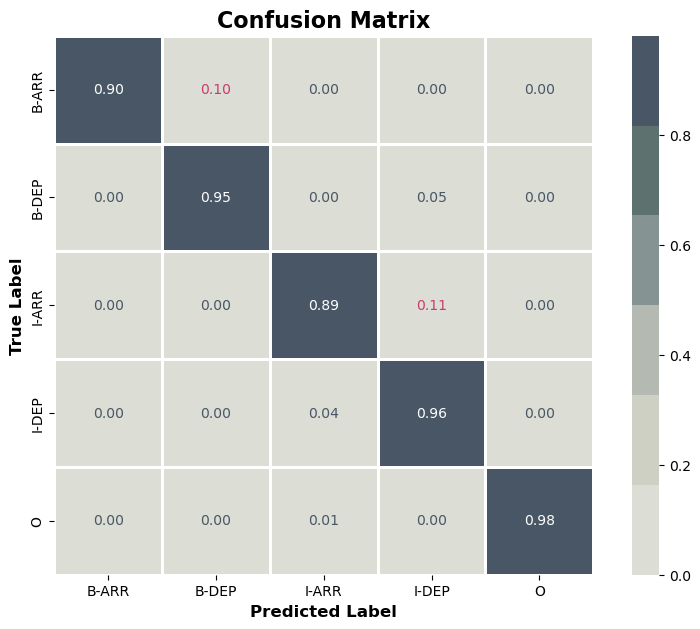


Confusion Matrix:
[[ 18   2   0   0   0]
 [  0  21   0   1   0]
 [  0   0  51   6   0]
 [  0   0   3  78   0]
 [  2   1   6   2 529]]

Classification Report:
              precision    recall  f1-score   support

           O       0.90      0.90      0.90        20
       B-DEP       0.88      0.95      0.91        22
       I-DEP       0.85      0.89      0.87        57
       B-ARR       0.90      0.96      0.93        81
       I-ARR       1.00      0.98      0.99       540

    accuracy                           0.97       720
   macro avg       0.90      0.94      0.92       720
weighted avg       0.97      0.97      0.97       720



In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Model evaluation
evaluation_results = model.evaluate(test_tokens, test_labels)
print("Evaluation results:", evaluation_results)

test_predictions = model.predict(test_tokens).logits
predicted_labels = np.argmax(test_predictions, axis=-1).flatten()

true_labels = test_labels.flatten() 

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # le nb de vrais labels pour chaque classe

# Heatmap
plt.figure(figsize=(10, 7))
custom_palette = ["#DCDED6", "#CED0C3", "#B4BAB1", "#859393", "#5D726F", "#485665"]
ax = sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap=custom_palette, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, square=True, linewidths=2, linecolor='white')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10, fontweight='normal')
plt.yticks(fontsize=10, fontweight='normal')

# color based on value
for text in ax.texts:
    t = float(text.get_text())
    if 0.1 <= t < 0.7:
        text.set_color('#CA3C66')
    elif t >= 0.7:
        text.set_color('#FFFFFF')
    else:
        text.set_color('#485665')

plt.show()

# Confusion Matrix stdout
confusion = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(confusion)

# Classification Report stdout
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels))

### Prédiction et évaluation

In [8]:
from sklearn.preprocessing import LabelEncoder

unique_labels = ['O', 'B-DEP', 'I-DEP', 'B-ARR', 'I-ARR']
label_encoder = LabelEncoder()
label_encoder.fit(unique_labels)

new_phrase = "demain, je planifie un voyage de Saint-Germain-en-Laye à L'Haÿ-les-Roses, en passant prendre des amis à Asnières-sur-Seine et peut-être faire une halte à Vitry-sur-Seine pour le déjeuner"

# Encodde data with correspondant labels
encoded_data = encode_data(pd.DataFrame([{'Phrase': new_phrase, 'Départ': 'Saint-Germain-en-Laye', 'Arrivée': "L'Haÿ-les-Roses"}]), tokenizer, label_encoder, max_length=36)
new_tokens, new_labels = encoded_data

# Model prediction
new_predictions = model.predict(new_tokens).logits
new_predicted_labels = np.argmax(new_predictions, axis=-1)

# Convert ids to text label
predicted_label_names = [label_encoder.inverse_transform([label_id])[0] for label_id in new_predicted_labels[0]]

# Get true label
true_labels = [label_encoder.inverse_transform([label_id])[0] for label_id in new_labels[0]]

# Check success
prediction_success = predicted_label_names == true_labels
print("\nPrediction success:", prediction_success)

# Result
tokens_with_special_tokens = tokenizer.convert_ids_to_tokens(new_tokens[0])

print("\nResult:")
print("{:<14} {:<10} {:<8} {:<6}".format("Token", "Predicted", "True", "Result"))
print("-" * 42)

for token, predicted_label, true_label in zip(tokens_with_special_tokens, predicted_label_names, true_labels):
    result = "✔️" if predicted_label == true_label else "❌"
    print("{:<14} {:<10} {:<8} {:<6}".format(token, predicted_label, true_label, result))

# Classification Report stdout
print("\nDetailed classification report:")
print(classification_report(true_labels, predicted_label_names, target_names=label_encoder.classes_))



---> Ligne 1
- Original sentence:  demain, je planifie un voyage de Saint-Germain-en-Laye à L'Haÿ-les-Roses, en passant prendre des amis à Asnières-sur-Seine et peut-être faire une halte à Vitry-sur-Seine pour le déjeuner.
- Encoded tokens:  ['[CLS]', 'dem', '##ain', ',', 'je', 'plan', '##if', '##ie', 'un', 'voyage', 'de', 'Saint', '-', 'Germain', '-', 'en', '-', 'Lay', '##e', 'à', 'L', "'", 'Ha', '##ÿ', '-', 'les', '-', 'Roses', ',', 'en', 'passant', 'prendre', 'des', 'amis', 'à', '[SEP]']
- Labels after encoding the entities:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DEP', 'I-DEP', 'I-DEP', 'I-DEP', 'I-DEP', 'I-DEP', 'I-DEP', 'I-DEP', 'O', 'B-ARR', 'I-ARR', 'I-ARR', 'I-ARR', 'I-ARR', 'I-ARR', 'I-ARR', 'I-ARR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
- Label IDs [4 4 4 4 4 4 4 4 4 4 4 1 3 3 3 3 3 3 3 4 0 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4]

// Encoding completed
1/1 [==============================] - 0s 119ms/step

Prediction success: True

Result:
Token          Predict

### Conclusion
On a un modèle dans l'ensemble assez performant qui a une accuracy moyenne de 97% à l'évaluation de tous labels confondu, sur les données de test.   
Et on voit qu'il s'en sort bien sur une tâche de prediction avec une phrase complexe en entrée.
